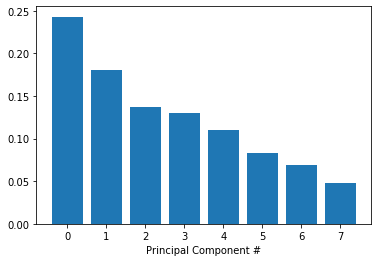

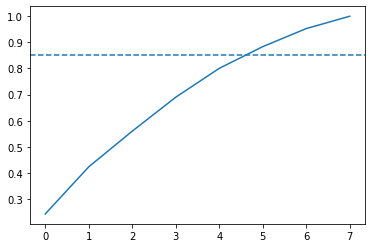

In [6]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']], on="track_id" )

# Define our features 
features = echo_tracks.drop(columns=['genre_top','track_id'])

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)


Decision trees are rule based classifiers folling a brancha nd leaf structure through levels of binary decisions to classify a data point.  Decision trees provides a visual representation of the logic behin the classification.

In [7]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In order to determine which model will work best wiht out dat we will also train Logistic Regression model. Logistic Regressions usses the logistic function to calculate the odds that a given data point belongs to a given category. 

In [8]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree )
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.66      0.66       229
        Rock       0.92      0.92      0.92       972

    accuracy                           0.87      1201
   macro avg       0.79      0.79      0.79      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.57      0.65       229
        Rock       0.90      0.95      0.93       972

    accuracy                           0.88      1201
   macro avg       0.83      0.76      0.79      1201
weighted avg       0.87      0.88      0.87      1201



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Both algorithms perform well, managing an 87% precisions core each. After analyzing the classification report it can be seen that rock sons are well classified but hip hop songs have a higher rate of misclassification. The reason behind this disparity could be the imbalance of hip hop and rock songs in the data set. To account for this we can sample from the rock songs so taht we have equal amounts of both categories in our dataset.

In [9]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

Although resampling removes the imbalance we also risk losing data points that could have been important to the training of our models. We will not check to see if resampling really did remove the unbalanced bias and if we have lost crucial information in our training set.

In [10]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier()
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression()
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.78      0.79       230
        Rock       0.78      0.79      0.78       225

    accuracy                           0.78       455
   macro avg       0.78      0.78      0.78       455
weighted avg       0.78      0.78      0.78       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.83      0.82       230
        Rock       0.82      0.81      0.82       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Balancing the data has removed the rockc bias from the models. Now to evaluate how well the models are actually performing we will perform a KFold cross validation method. Cross Validation attempts to split the data multiple ways and test the model on each split. The average of the scores from each split is then considered to be a fuller picture of the models performance. 

In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7241758241758242 Logistic Regression: 0.7752747252747252


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  